<a href="https://colab.research.google.com/github/Sachin270/CMLAssignment2/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls /content/drive/'MyDrive'/'Colab Notebooks'/

'Assignment2 (1).ipynb'       Image_classification_data.zip
 Assignment2.ipynb	      patch_images
 Assignment2_s3714805.ipynb   Untitled0.ipynb
 CMLAssignment2-main.zip      Untitled2.ipynb
 data_labels_extraData.csv   'Untitled8 (1).ipynb'
 data_labels_mainData.csv     Untitled8.ipynb


In [ ]:
!cp /content/drive/'MyDrive'/'Colab Notebooks'/'Image_classification_data.zip' .
!unzip -q -o 'Image_classification_data.zip'
!rm 'Image_classification_data.zip'
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from tensorflow.keras.layers import Dense
import tensorflow as tf

In [ ]:
data = pd.read_csv('./data_labels_mainData.csv')
OUTPUT_CLASSES = 4
data.columns

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')

# New Section

In [ ]:
data.groupby('cellTypeName').agg('count')

,InstanceID,patientID,ImageName,cellType,isCancerous
cellTypeName,,,,,
epithelial,4079,4079,4079,4079,4079
fibroblast,1888,1888,1888,1888,1888
inflammatory,2543,2543,2543,2543,2543
others,1386,1386,1386,1386,1386


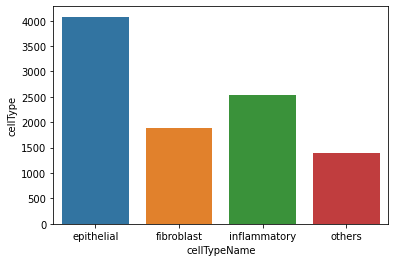

In [ ]:
sns.barplot(x=data.groupby('cellTypeName').agg('count').index, 
            y='cellType',
            data=data.groupby('cellTypeName').agg('count'))

In [ ]:
data.groupby('isCancerous').agg('count')

,InstanceID,patientID,ImageName,cellTypeName,cellType
isCancerous,,,,,
0,5817,5817,5817,5817,5817
1,4079,4079,4079,4079,4079


In [ ]:
sns.barplot(x=mergeData.groupby('isCancerous').agg('count').index, 
            y='cellType', 
            data=data.groupby('isCancerous').agg('count'))

In [ ]:
data.groupby(['cellTypeName', 'isCancerous']).agg('count')

,,InstanceID,patientID,ImageName,cellType
cellTypeName,isCancerous,,,,
epithelial,1,4079,4079,4079,4079
fibroblast,0,1888,1888,1888,1888
inflammatory,0,2543,2543,2543,2543
others,0,1386,1386,1386,1386


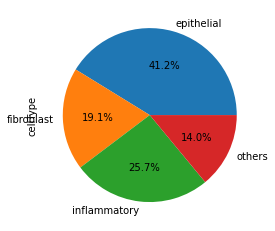

In [ ]:
data.groupby('cellTypeName').agg('count').cellType.plot.pie(autopct="%.1f%%")

In [ ]:
extraData = pd.read_csv('data_labels_extraData.csv')
extraData.columns

Index(['InstanceID', 'patientID', 'ImageName', 'isCancerous'], dtype='object')

In [ ]:
mergedData = pd.concat([data[["InstanceID", "patientID", "ImageName", "isCancerous"]], extraData])

In [ ]:
OUTPUT_CLASSES = 2

train_data, test_data = train_test_split(mergedData, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


In [ ]:
train_data['Class'] = train_data['isCancerous'].astype('str')
val_data['Class'] = val_data['isCancerous'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [ ]:

reg_lambda = 0.0001
modelCancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(54, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim([0, 1])
    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")                                                  
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim([0, 1])
    plt.show()

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
 monitor='val_categorical_accuracy', 
 verbose=1,
 patience=20,
 mode='max',
 restore_best_weights=True)

In [ ]:
modelCancerous.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam"),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [ ]:
historyCancerous = modelCancerous.fit(train_generator, validation_data = validation_generator,callbacks= [early_stopping], epochs=50)

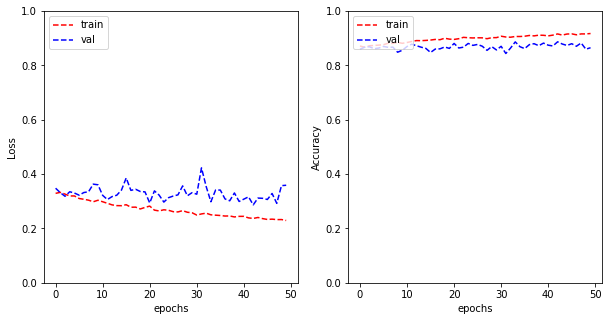

In [ ]:
plot_learning_curve(historyCancerous.history['loss'], historyCancerous.history['val_loss'], 
                    historyCancerous.history['categorical_accuracy'], historyCancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
reg_lambda = 0.00001

modelCancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same',  
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [ ]:
modelCancerous.compile(tf.keras.optimizers.Adam(learning_rate=0.00001,name="Adam"),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [ ]:
historyCancerous = modelCancerous.fit(train_generator, validation_data = validation_generator,callbacks=[early_stopping], epochs=50)

Epoch 1/50
451/451 [==============================] - 44s 27ms/step - loss: 0.6289 - categorical_accuracy: 0.6519 - val_loss: 0.5840 - val_categorical_accuracy: 0.6575
Epoch 2/50
451/451 [==============================] - 12s 26ms/step - loss: 0.5120 - categorical_accuracy: 0.7688 - val_loss: 0.5105 - val_categorical_accuracy: 0.7424
Epoch 3/50
451/451 [==============================] - 12s 26ms/step - loss: 0.4634 - categorical_accuracy: 0.7888 - val_loss: 0.4844 - val_categorical_accuracy: 0.7616
Epoch 4/50
451/451 [==============================] - 12s 26ms/step - loss: 0.4565 - categorical_accuracy: 0.7881 - val_loss: 0.4975 - val_categorical_accuracy: 0.7562
Epoch 5/50
451/451 [==============================] - 12s 26ms/step - loss: 0.4455 - categorical_accuracy: 0.7923 - val_loss: 0.4401 - val_categorical_accuracy: 0.7843
Epoch 6/50
451/451 [==============================] - 12s 26ms/step - loss: 0.4368 - categorical_accuracy: 0.8010 - val_loss: 0.4326 - val_categorical_accuracy:

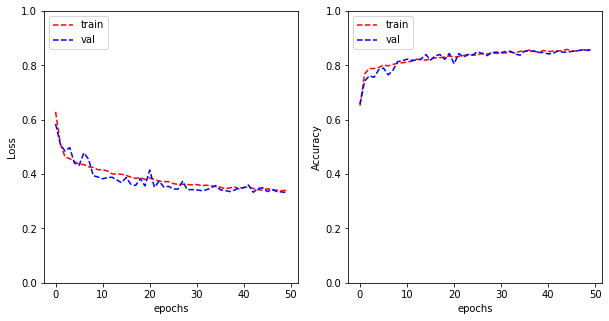

In [ ]:
plot_learning_curve(historyCancerous.history['loss'], historyCancerous.history['val_loss'], 
                    historyCancerous.history['categorical_accuracy'], historyCancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 1
                                                                       
# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in validation_generator:
        y_hat = modelCancerous.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print("Confusion Matrix ", confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.8552859857351361
F1 score:  0.8357058444039311
[[65391  6238]
 [ 9527 27783]]


In [ ]:
modelCancerous.save("modelCancerous")

INFO:tensorflow:Assets written to: modelCancerous/assets


In [ ]:
## Only on colab
# Change according to your directory structure
!cp -R ./modelCancerous/content/drive/'My Drive'/'Colab Notebooks'      

cp: missing destination file operand after './modelCancerous/content/drive/My Drive/Colab Notebooks'
Try 'cp --help' for more information.


In [ ]:
modelCancerous.summary()

In [ ]:
from tensorflow import keras
modelCelltype = keras.models.load_model('/content/modelCancerous')

In [ ]:
modelCelltype.summary()

In [ ]:
modelCelltype.pop()

In [ ]:
modelCelltype.add(Dense(4, activation='softmax'))

In [ ]:
modelCelltype.summary()

In [ ]:
modelCelltype = modelCancerous

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./data_labels_mainData.csv')

OUTPUT_CLASSES = 4

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [ ]:
train_data['Class'] = train_data['cellType'].astype('str')
val_data['Class'] = val_data['cellType'].astype('str')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [ ]:
modelCelltype.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="adam"),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
 monitor='val_sparse_categorical_accuracy', 
 verbose=1,
 patience=20,
 mode='max',
 restore_best_weights=True)

In [ ]:
class_weight = {0: 1.,1: 2.,2: 2., 3: 1.}

In [ ]:
class_weights={"class_1": 1, "class_2": 10}

In [ ]:
from sklearn.utils import class_weight

In [ ]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

In [ ]:
historyCancerous = modelCelltype.fit(train_generator, validation_data = validation_generator,class_weight=class_weights, callbacks=[early_stopping], epochs=50)

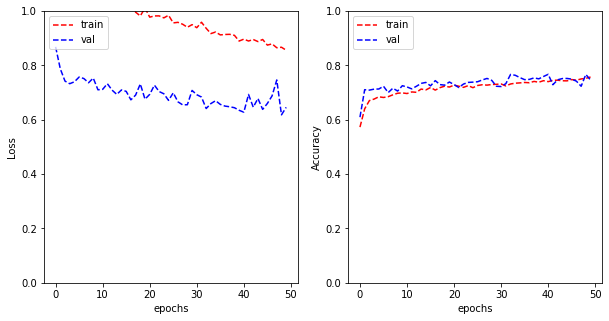

In [ ]:
plot_learning_curve(historyCancerous.history['loss'], historyCancerous.history['val_loss'], 
                    historyCancerous.history['sparse_categorical_accuracy'], historyCancerous.history['val_sparse_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 1

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in validation_generator:
        y_hat = modelCelltype.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        # y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print("Confusion Matrix ")
print(confusion_matrix(y_all, y_hat_all))
print(classification_report(y_all, y_hat_all))

Accuracy score:  0.7391706985182945
F1 score:  0.6952053873997759
Confusion Matrix 
[[ 7837   696   666  1014]
 [  691 10670   591  1633]
 [ 3204  1287 17125    27]
 [ 1204  2332   456  3479]]


In [ ]:
test_data['Class'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 1980 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
model_VGG_2.evaluate(test_generator)

1980/1980 [==============================] - 9s 4ms/step - loss: 1.5789 - sparse_categorical_accuracy: 0.7283


[1.578864574432373, 0.7282828092575073]

In [ ]:
model_VGG_3.optimizer.get_config()